# Live AQI Monitoring

This notebook demonstrates how to monitor real-time air quality data using cpcbfetch.

In [15]:
from cpcbfetch import LiveAQIClient
import json
import time
from datetime import datetime
import pandas as pd

## 1. Get Your Location

First, let's find your approximate location using IP-based geolocation.

In [16]:
# Initialize the Live AQI client
client = LiveAQIClient()

# Get your location
location = client.get_system_location()
print("Your Location:")
print(json.dumps(location, indent=2))

Your Location:
[
  19.0748,
  72.8856
]


## 2. Find Nearest Monitoring Station

Find the closest air quality monitoring station to your location.

In [17]:
# Find nearest station
nearest_station = client.get_nearest_station()
print("Nearest Monitoring Station:")

# Extract station ID for future use
station_id = nearest_station[0]
station_name = nearest_station[1]
print(f"\nMonitoring Station ID: {station_id}")
print(f"Station Name: {station_name}")

Nearest Monitoring Station:

Monitoring Station ID: site_5104
Station Name: Kurla, Mumbai - MPCB


## 3. Get Current Air Quality Data

Fetch the latest air quality measurements from the nearest station.

In [18]:
# Get current AQI data
aqi_data = client.get_live_aqi_data(station_id=station_id)

if isinstance(aqi_data, Exception):
    print(f"❌ {aqi_data}")
print(f"Current Air Quality at {station_name}:")
metrics = aqi_data.get('metrics', [])
if metrics:
    print("Pollutant   Avg   Min   Max   Period")
    print("-" * 40)
    for m in metrics:
        print(f"{m['name']:<10} {m['avg']:<5} {m['min']:<5} {m['max']:<5} {m['avgDesc']}")
else:
    print("No data available, possibly due to station being offline.")

Current Air Quality at Kurla, Mumbai - MPCB:
Pollutant   Avg   Min   Max   Period
----------------------------------------
PM2.5      51    42    148   Over the last 24 hours
PM10       57    47    147   Over the last 24 hours
NO2        4     3     7     Over the last 24 hours
NH3        1     1     2     Over the last 24 hours
SO2        37    36    37    Over the last 24 hours
CO         6     2     17    Over the last 8 hours
OZONE      28    28    38    Over the last 8 hours


## 4. Continuous Monitoring

Set up a simple monitoring loop to track air quality changes over time.

**Note:** This will run continuously. Stop the cell when you want to end monitoring.

C:\Users\mahes\AppData\Local\Temp\ipykernel_18924\2686430132.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates_dt = pd.to_datetime(dates)
C:\Users\mahes\AppData\Local\Temp\ipykernel_18924\2686430132.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates_dt = pd.to_datetime(dates)
C:\Users\mahes\AppData\Local\Temp\ipykernel_18924\2686430132.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates_dt = pd.to_datetime(dates)
C:\Users\mahes\AppData\Local\Temp\ipykernel_18924\2686430132.py:19: UserWarning: Could not infer format, so each element will be parsed ind

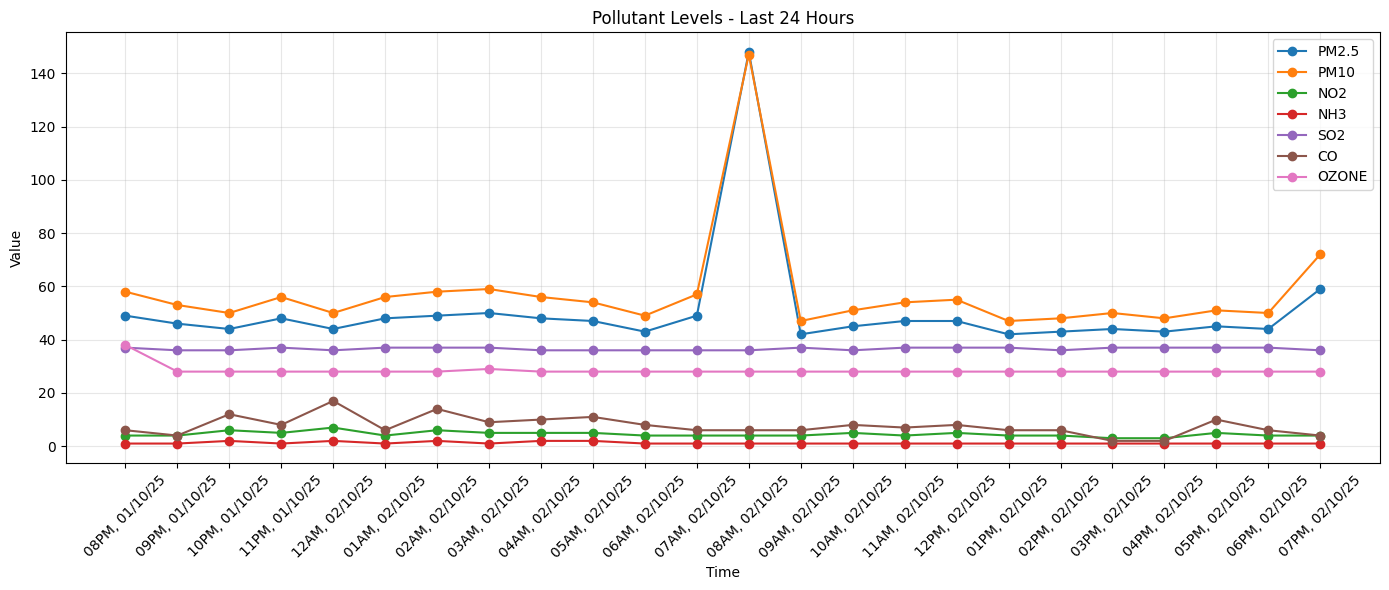


PM2.5 Analysis:
  Min: 42
  Max: 148
  Mean: 50.58

PM10 Analysis:
  Min: 47
  Max: 147
  Mean: 57.33

NO2 Analysis:
  Min: 3
  Max: 7
  Mean: 4.50

NH3 Analysis:
  Min: 1
  Max: 2
  Mean: 1.21

SO2 Analysis:
  Min: 36
  Max: 37
  Mean: 36.54

CO Analysis:
  Min: 2
  Max: 17
  Mean: 7.58

OZONE Analysis:
  Min: 28
  Max: 38
  Mean: 28.46


In [21]:
import matplotlib.pyplot as plt

# Analyze and plot time series for each pollutant in last_hours
# Collect all pollutants' time series
pollutant_names = []
all_values = []
all_dates = None

for pollutant in aqi_data['last_hours']:
    name = pollutant['name']
    data = pollutant['data']
    if not data:
        continue

    dates = [entry['date'] for entry in data]
    values = [entry['val'] for entry in data]

    # Convert dates to datetime
    dates_dt = pd.to_datetime(dates)
    pollutant_names.append(name)
    all_values.append(values)
    if all_dates is None:
        all_dates = dates_dt

# Format x-axis labels as "HourAM/PM, DD/MM/YY"
x_labels = [dt.strftime('%I%p, %d/%m/%y').replace('AM', 'AM').replace('PM', 'PM') for dt in all_dates]

plt.figure(figsize=(14, 6))
for i, values in enumerate(all_values):
    plt.plot(all_dates, values, marker='o', label=pollutant_names[i])

plt.title(f"Pollutant Levels - Last {len(all_dates)} Hours")
plt.xlabel("Time")
plt.ylabel("Value")
plt.xticks(all_dates, x_labels, rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()

# Show min, max, mean for each pollutant
for i, values in enumerate(all_values):
    print(f"\n{pollutant_names[i]} Analysis:")
    print(f"  Min: {min(values)}")
    print(f"  Max: {max(values)}")
    print(f"  Mean: {sum(values)/len(values):.2f}")

## 5. Set Up Alerts

Create a simple alert system for unhealthy air quality levels.

In [23]:
def check_air_quality_alert(aqi_value):
    """
    Check AQI and return alert level.
    
    AQI Categories:
    - 0-50: Good
    - 51-100: Satisfactory
    - 101-200: Moderate
    - 201-300: Poor
    - 301-400: Very Poor
    - 401+: Severe
    """
    if aqi_value <= 50:
        return "✅ Good", "Air quality is good. Enjoy outdoor activities!"
    elif aqi_value <= 100:
        return "🟢 Satisfactory", "Air quality is acceptable."
    elif aqi_value <= 200:
        return "🟡 Moderate", "Sensitive individuals should limit prolonged outdoor exposure."
    elif aqi_value <= 300:
        return "🟠 Poor", "Everyone may begin to experience health effects. Reduce outdoor activities."
    elif aqi_value <= 400:
        return "🔴 Very Poor", "Health alert! Everyone should avoid outdoor activities."
    else:
        return "🆘 Severe", "Health emergency! Stay indoors and avoid any outdoor exposure."

# Check current AQI
if aqi_data and 'aqi' in aqi_data:
    print(aqi_data['aqi'])
    current_aqi = aqi_data['aqi']
    alert_level, message = check_air_quality_alert(current_aqi['value'])
    
    print(f"\nCurrent AQI: {current_aqi}")
    print(f"Alert Level: {alert_level}")
    print(f"Recommendation: {message}")

{'param': 'PM10', 'value': 57, 'remark': 'Satisfactory', 'color': '#009933'}

Current AQI: {'param': 'PM10', 'value': 57, 'remark': 'Satisfactory', 'color': '#009933'}
Alert Level: 🟢 Satisfactory
Recommendation: Air quality is acceptable.


## 6. Get AQI for Specific Coordinates

You can also get AQI data for any specific location by providing coordinates.

In [20]:
# Example: Get AQI for Mumbai coordinates
mumbai_lat = 19.0760
mumbai_lon = 72.8777

coords = (mumbai_lat, mumbai_lon)

# Find nearest station to these coordinates
mumbai_station = client.get_nearest_station(coords=coords)
print("Nearest station to Mumbai:")
print(json.dumps(mumbai_station, indent=2))

# Get AQI data for that location
mumbai_aqi = client.get_live_aqi_data(coords=coords)
print("\nCurrent AQI in Mumbai:")
print(json.dumps(mumbai_aqi, indent=2))

Nearest station to Mumbai:
[
  "site_5104",
  "Kurla, Mumbai - MPCB"
]

Current AQI in Mumbai:
{
  "title": "Kurla, Mumbai - MPCB",
  "nOfCom": 100,
  "down": "false",
  "downmessage": "",
  "date": "Thursday, 02 Oct 2025 07:00 PM",
  "temp": "",
  "aqi": {
    "param": "PM10",
    "value": 57,
    "remark": "Satisfactory",
    "color": "#009933"
  },
  "metrics": [
    {
      "name": "PM2.5",
      "avg": 51,
      "avgDesc": "Over the last 24 hours",
      "min": 42,
      "max": 148,
      "pollutantName": "PM2.5"
    },
    {
      "name": "PM10",
      "avg": 57,
      "avgDesc": "Over the last 24 hours",
      "min": 47,
      "max": 147,
      "pollutantName": "PM10"
    },
    {
      "name": "NO2",
      "avg": 4,
      "avgDesc": "Over the last 24 hours",
      "min": 3,
      "max": 7,
      "pollutantName": "NO2"
    },
    {
      "name": "NH3",
      "avg": 1,
      "avgDesc": "Over the last 24 hours",
      "min": 1,
      "max": 2,
      "pollutantName": "NH3"
    },
 

## Conclusion

This notebook demonstrated:
- Getting your current location
- Finding nearest monitoring stations
- Fetching real-time air quality data
- Visualizing last 24 hour data
- Creating alerts based on AQI levels

You can extend this by:
- Adding email/SMS alerts
- Monitoring multiple stations
- Creating dashboards with real-time updates
- Integrating with IoT devices